In [18]:
import ase
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.fft import fftn, ifftn, fftfreq
import matplotlib.cm as cm
from numpy import linalg as LA
from tqdm import tqdm_notebook
from tqdm.notebook import trange,tqdm
from ase.io import read, write
from ase.neighborlist import build_neighbor_list, natural_cutoffs
from ase.build import make_supercell
import multiprocessing as mp
from multiprocessing import Pool
import os

### Fe BCC vs. FCC lattice 

In [4]:
positions_skipped=[]
unitcells=[]
nskip=1000
natoms=4
nbeads=1
for count, filename in tqdm(enumerate(os.listdir("Fe-FCC/unitcell/"))): 
    src="Fe-FCC/unitcell/"+filename
    with open(src,"r") as f:
        #store each bead info.
        positions=[]
        for lines in f:
            line=lines.split()
            if(len(line)==3):
                unitcells.append([float(u) for u in line])
            if(len(unitcells)%3==0): 
                unitcell=[]
                for u in unitcells[-3:]:
                    unitcell+=[u[1]-u[0]]
                #print(unitcell)
            if(len(line)==5):
                position=[float(pos) for pos in line]
                position=position[2:]
                positions.append([a*b for a,b in zip(position,unitcell)])
        positions_skipped+=[positions[nskip*natoms:]]

atoms=np.asarray(positions_skipped[0])

In [5]:
#np.savetxt("atoms-fcc-unit.csv", atoms, delimiter=",")
atoms.shape[0]/4

9001.0

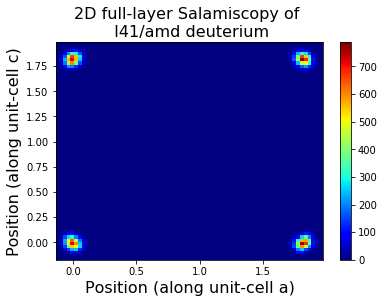

In [26]:
salamiscope_xy=atoms[:,[0,1]]
salamiscope_yz=atoms[:,[1,2]]
salamiscope_xz=atoms[:,[0,2]]

#nskip=0
plt.title("2D full-layer Salamiscopy of \n I41/amd deuterium", fontsize=16)
plt.hist2d(salamiscope_xz[:,0],salamiscope_xz[:,1],bins=70,cmap=plt.cm.jet)
#plt.hist2d(salamiscope_yz[:,0],salamiscope_yz[:,1],bins=70,cmap=plt.cm.jet)
#plt.hist2d(salamiscope_xy[:,0],salamiscope_xy[:,1],bins=70,cmap=plt.cm.jet)

#plt.scatter(salamiscope_xz_sl[:128,0],salamiscope_xz_sl[:128,1],facecolors='none', edgecolors='black',s=100,linewidths=2)
#plt.scatter(salamiscope_xz[:128,0],salamiscope_xz[:128,1],c='red')
plt.colorbar()
plt.xlabel('Position (along unit-cell a)', fontsize=16)
plt.ylabel('Position (along unit-cell c)', fontsize=16)

plt.show()
#plt.savefig('salami-md-xz.png',dpi=400,bbox_inches = "tight")

In [7]:
a=atoms

alata=2.87*1
alatc=2.87*1

hkl=2
N=200
pos_grid=np.zeros((N+1,N+1,N+1))

q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in trange(a.shape[0]):
    idx=np.absolute(rgrida-a[i,0]).argmin()
    idy=np.absolute(rgrida-a[i,1]).argmin()
    idz=np.absolute(rgridc-a[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1/9901

In [45]:
#Fourier transform
#pos_grid=np.random.rand(N+1,N+1,N+1)
Sq_fft=fftn(pos_grid)
Sq_fft=np.real(Sq_fft)

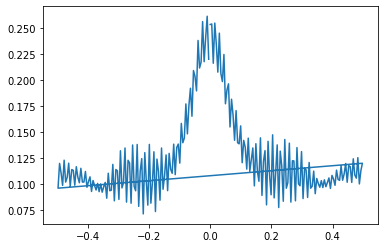

In [46]:
plt.plot((fftfreq(n=N+1)), Sq_fft[100,100,:])
#plt.plot((np.arange(N+1)/N), Sq_fft[200,200,:])

In [11]:
def sample_Sq(klist):
    print(alata,alatc,Sq_fft.shape)
    q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)
    Sqq=np.zeros(q.shape[0])
    for i in tqdm(klist):
        for j in range(N*hkl-1):
            for k in range(N*hkl-1):
                r0=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_a=np.sqrt(2*np.pi/alata*((i+1)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_b=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k+1)/N)**2)
                r1=np.maximum(r1_a,r1_b)

                Sq=Sq_fft[int(i%Sq_fft.shape[0]),int(j%Sq_fft.shape[1]),int(k%Sq_fft.shape[2])]/(4/3*np.pi*(r1**3-r0**3))
                Sqq[np.abs(q-r0).argmin()]+=Sq
    return Sqq

In [12]:
num_cores=mp.cpu_count()
print(num_cores)
pool=Pool(num_cores)
klist_tot=range(N*hkl-1)
chunks=[klist_tot[i::num_cores] for i in range(num_cores)]

Sqq=[]
for Sqq_join in pool.map(sample_Sq, chunks):
    Sqq+=[Sqq_join]
pool.close()

8
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)
2.87 2.87 (201, 201, 201)


In [13]:
q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)
Sqqf=np.zeros(q.shape[0])
for s in Sqq:
    Sqqf+=s

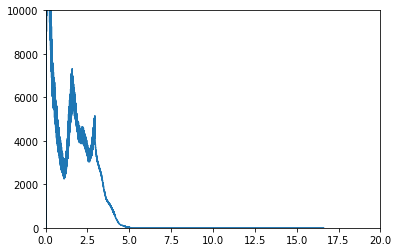

In [17]:
plt.ylim(0,10000)
plt.xlim(0,20)
plt.plot(q[:],Sqqf[:])

In [29]:
Sq_bcc=np.loadtxt('./sq.dat-bcc')
Sq_fcc=np.loadtxt('./sq.dat-fcc')

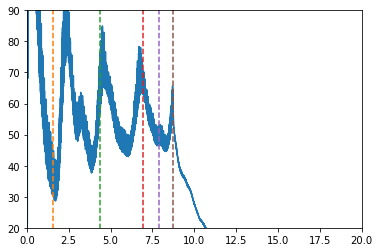

In [30]:
peak1=(1*np.pi/2.87)*np.sqrt(1**2+1**2+0**2)
peak2=(2*np.pi/2.87)*np.sqrt(2**2+0**2+0**2)
peak3=(2*np.pi/2.87)*np.sqrt(3**2+1**2+0**2)
peak4=(2*np.pi/2.87)*np.sqrt(3**2+2**2+0**2)
peak5=(2*np.pi/2.87)*np.sqrt(4**2+0**2+0**2)

peaks=[
       [peak1,peak1],
       [peak2,peak2],
       [peak3,peak3],
       [peak4,peak4],
       [peak5,peak5]
      ]
peak_2=[0,100000]

plt.ylim(20,90)
plt.xlim((0),20)
plt.plot(Sq_bcc[:,0], Sq_bcc[:,1])
#plt.plot(Sq_fcc[:,0], Sq_fcc[:,1])

plt.plot(peaks[0],peak_2,'--')
plt.plot(peaks[1],peak_2,'--')
plt.plot(peaks[2],peak_2,'--')
plt.plot(peaks[3],peak_2,'--')
plt.plot(peaks[4],peak_2,'--')

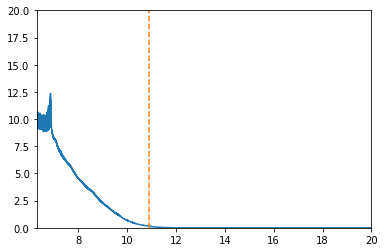

In [49]:
peak1=(2*np.pi/1)*np.sqrt(1**2 + 1**2 + 1**2)
peak2=(2*np.pi/1)*np.sqrt(2**2 + 2**2 + 0**2)

peaks=[
       [peak1,peak1],
       [peak2,peak2],
       [peak3,peak3],
       [peak4,peak4],
       [peak5,peak5]
      ]
peak_2=[0,100000]


plt.ylim(0,20)
plt.xlim((2*np.pi/1),20)
plt.plot(Sq_fcc[:,0], Sq_fcc[:,1])

plt.plot(peaks[0],peak_2,'--')


### supersolid phase

In [2]:
a=np.loadtxt("../Results/atoms-pimd-65.csv", delimiter=",")
#a=np.loadtxt("../Results/atoms-116.csv", delimiter=",")

In [3]:
a.shape[0]/128/128

65.0

In [4]:
alata=4.38
alatc=6.33

hkl=2
N=128
pos_grid=np.zeros((N+1,N+1,N+1))

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in trange(a.shape[0]):
    idx=np.absolute(rgrida-a[i,0]).argmin()
    idy=np.absolute(rgrida-a[i,1]).argmin()
    idz=np.absolute(rgridc-a[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1/65/128

In [5]:
#Fourier transform
#pos_grid=np.random.rand(N+1,N+1,N+1)
Sq_fft=fftn(pos_grid)
Sq_fft=np.absolute(Sq_fft/np.count_nonzero(pos_grid))

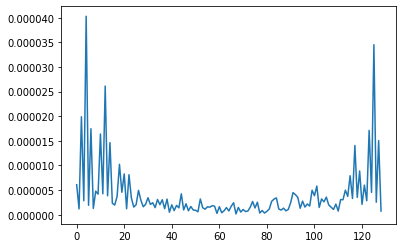

In [6]:
plt.plot(range(N+1),   Sq_fft[12,32,:])
#plt.plot(range(N+1),4*Ssq_fft[12,32,:])

In [7]:
def sample_Sq(klist):
    print(alata,alatc,Sq_fft.shape)
    q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)
    Sqq=np.zeros(q.shape[0])
    for i in tqdm(klist):
        for j in range(N*hkl-1):
            for k in range(N*hkl-1):
                r0=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_a=np.sqrt(2*np.pi/alata*((i+1)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_b=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k+1)/N)**2)
                r1=np.maximum(r1_a,r1_b)

                Sq=Sq_fft[int(i%Sq_fft.shape[0]),int(j%Sq_fft.shape[1]),int(k%Sq_fft.shape[2])]/(4/3*np.pi*(r1**3-r0**3))
                Sqq[np.abs(q-r0).argmin()]+=Sq
    return Sqq

In [8]:
num_cores=mp.cpu_count()
print(num_cores)
pool=Pool(num_cores)
klist_tot=range(N*hkl-1)
chunks=[klist_tot[i::num_cores] for i in range(num_cores)]

#sample_Sq(chunks[1])

#Sqq = [pool.apply(sample_Sq, args=(row,Sq_fft)) for row in tqdm(chunks)]
#pool.close()

Sqq=[]
for Sqq_join in pool.map(sample_Sq, chunks):
    Sqq+=[Sqq_join]
pool.close()

8
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)
4.38 6.33 (129, 129, 129)


In [9]:
q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)
Sqqf=np.zeros(q.shape[0])
for s in Sqq:
    Sqqf+=s

In [10]:
Sqqf_s=Sqqf

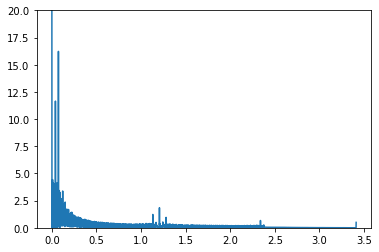

In [11]:
#plt.xlim(0.0,2)
plt.ylim(0,20)
plt.plot(q[:],Sqqf_s[:])

### solid supercell

In [2]:
a=read('./Deuterium/CPOSCAR.xyz')

alata=4.28
alatc=5.966

hkl=4
N=128
pos_grid=np.zeros((N+1,N+1,N+1))

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in range(a.positions.shape[0]):
    idx=np.absolute(rgrida-a.positions[i,0]).argmin()
    idy=np.absolute(rgrida-a.positions[i,1]).argmin()
    idz=np.absolute(rgridc-a.positions[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1

In [3]:
#Fourier transform
Sq_fft=fftn(pos_grid)
Sq_fft=np.absolute(Sq_fft/np.count_nonzero(pos_grid))
#q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)

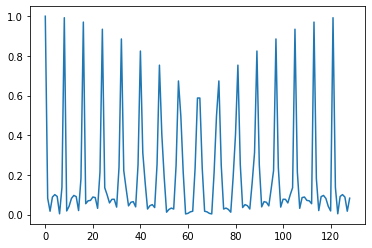

In [4]:
plt.plot(range(N+1),Sq_fft[0,0,:])

wrapper function

In [4]:
def sample_Sq(klist):
    print(alata,alatc,Sq_fft.shape)
    q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.01)
    Sqq=np.zeros(q.shape[0])
    for i in tqdm(klist):
        for j in range(N*hkl-1):
            for k in range(N*hkl-1):
                r0=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_a=np.sqrt(2*np.pi/alata*((i+1)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
                r1_b=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k+1)/N)**2)
                r1=np.maximum(r1_a,r1_b)

                Sq=Sq_fft[int(i%Sq_fft.shape[0]),int(j%Sq_fft.shape[1]),int(k%Sq_fft.shape[2])]/(4/3*np.pi*(r1**3-r0**3))
                Sqq[np.abs(q-r0).argmin()]+=Sq
    return Sqq

In [5]:
num_cores=mp.cpu_count()
pool=Pool(num_cores)
klist_tot=range(N*hkl-1)
chunks=[klist_tot[i::num_cores] for i in range(num_cores)]

#sample_Sq(chunks[1])

#Sqq = [pool.apply(sample_Sq, args=(row,Sq_fft)) for row in tqdm(chunks)]
#pool.close()

Sqq=[]
for Sqq_join in pool.map(sample_Sq, chunks):
    Sqq+=[Sqq_join]
pool.close()
#pool.join()

4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)
4.28 5.966 (129, 129, 129)


In [6]:
q=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.01)
Sqqf=np.zeros(q.shape[0])
for s in Sqq:
    Sqqf+=s

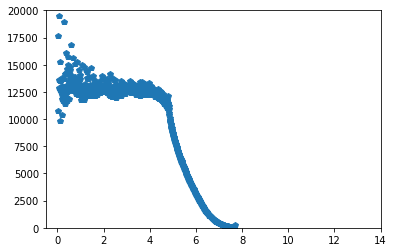

In [11]:
plt.xlim(-0.5,14)
plt.ylim(0,20000)
plt.plot(q[:],Sqqf[:],'p')

## Unitcell

In [327]:
a=read('./Deuterium/POSCAR-unit.xyz')

alata=1.1
alatc=3.18076514346

hkl=1
N=32
pos_grid=np.zeros((N+1,N+1,N+1))

rgrida=np.arange(0.0,alata+alata/N,alata/N)
rgridc=np.arange(0.0,alatc+alatc/N,alatc/N)

for i in range(a.positions.shape[0]):
    idx=np.absolute(rgrida-a.positions[i,0]).argmin()
    idy=np.absolute(rgrida-a.positions[i,1]).argmin()
    idz=np.absolute(rgridc-a.positions[i,2]).argmin()
    pos_grid[idx,idy,idz]+=1

In [328]:
#Fourier transform
Sq_fft=fftn(pos_grid)
Sq_fft=np.absolute(Sq_fft/np.count_nonzero(pos_grid))

This is too demanding and inefficient!

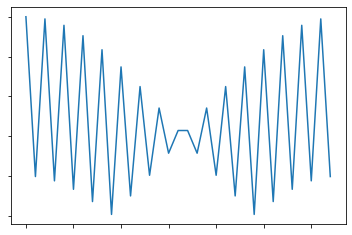

In [329]:
plt.plot(range((N+1)),Sq_fft[:,0,0])

In [333]:
q_u=(2*np.pi/alatc)*np.arange(0.0,hkl*2*np.pi/alatc*np.sqrt(3),0.001)
Sqq_u=np.zeros(q_u.shape[0])

for i in trange(N*hkl-1):
    for j in range(N*hkl-1):
        for k in range(N*hkl-1):
            r0=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
            r1_a=np.sqrt(2*np.pi/alata*((i+1)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k)/N)**2)
            r1_b=np.sqrt(2*np.pi/alata*((i)/N)**2 + 2*np.pi/alata*((j)/N)**2 + 2*np.pi/alatc*((k+1)/N)**2)
            r1=np.maximum(r1_a,r1_b)
            
            Sq=Sq_fft[int(i%Sq_fft.shape[0]),int(j%Sq_fft.shape[1]),int(k%Sq_fft.shape[2])]/(4/3*np.pi*(r1**3-r0**3))
            Sqq_u[np.abs(q_u-r0).argmin()]+=Sq

In [290]:
Sqq_u.shape

(343,)

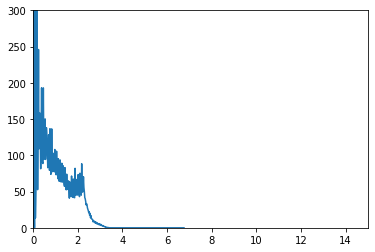

In [292]:
plt.ylim(0,300)
plt.xlim(0,15)
plt.plot(q_u[:],Sqq_u[:],'-')

### Plot: Solid vs. quantum solid phases

In [68]:
sq_solid=np.loadtxt('./sq.dat')
sq_qsolid=np.loadtxt('./sq.dat-q')

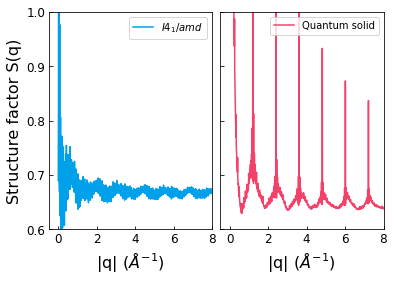

In [145]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=.05)

axs[0].set_ylim(0.6,1.0)
axs[0].set_xlim(-0.5,8.0)

axs[0].set_yticks(np.arange(0.6, 1.01, .1))
axs[0].tick_params(axis="y", labelsize=12, direction='in')

axs[0].set_xticks(np.arange(0.0, 8.01, 2.0))
axs[0].tick_params(axis="x", labelsize=12, direction='in')

axs[0].set_xlabel('|q| ($\AA^{-1}$)', fontsize=16)
axs[0].set_ylabel('Structure factor S(q)', fontsize=16)

axs[0].plot(sq_solid[:,0], sq_solid[:,1]/300000, color='#00A0EB', label='$I4_1/amd$')
axs[0].legend()

axs[1].set_xlabel('|q| ($\AA^{-1}$)', fontsize=16)
axs[1].tick_params(axis="x", labelsize=12, direction='in')
axs[1].tick_params(axis="y", labelsize=12, direction='in')

axs[1].plot(sq_qsolid[:,0], sq_qsolid[:,1]*2, color='#F54169', label='Quantum solid')
axs[1].legend()

In [ ]:
p 'sq.dat-q' u 1:($2*2) w l , 'sq.dat' u 1:($2/300000) w l